In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('..')

In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import utils.nn as tu
import utils.vis as vis
import utils.mp as mp
import utils.data as data
from pipelines.iae import InvertedAE 

from tqdm.auto import trange

T.__version__

'1.6.0'

In [3]:
msg_size = 1024
model = InvertedAE(msg_size=msg_size, img_channels=3).to('cuda')
model.summary()

 > Custom Module                          | 7,997,689
 >             criterion: MSELoss         |         0
 >               encoder: MsgEncoder      | 7,849,049
 >               decoder: MsgDecoder      |   148,640
 >                 noise: Sequential      |         0



In [4]:
msgs = T.randn(64, msg_size).to('cuda')
frame = model.encoder(msgs)
frame.shape

torch.Size([64, 3, 28, 28])

In [5]:
cmap = 'gray'

In [3]:
msgs = T.randn(64, msg_size).to('cuda')
its = 1024 * 50
import time

with vis.vid(vid_path=f'../.videos/inverted-ae-{cmap}.webm', fps=60) as vid, mp.fit(
    model=model,
    dataloader=model.get_data_gen(bs=128),
    epochs=1,
    its=its,
    optim_kw={'lr': 0.001}
) as fit:
    for i in fit.wait:
        if i % 200 == 0:
            frame = model.encoder(msgs)
            frame = frame.reshape(16, 4, *frame.shape[-3:])
            frame = frame.imshow(figsize=(16, 4), show=False, cmap=cmap)

            vid.append(frame)
        time.sleep(0.002)

In [1]:
vid.show()

In [28]:
frame = model.encoder(msgs)
frame = frame.reshape(16, 4, *frame.shape[-3:])
# frame = frame.imshow(figsize=(16, 4), show=False, cmap=cmap)
frame.shape

torch.Size([16, 4, 3, 28, 28])

In [29]:
# frame.shape
# import PIL

# im = PIL.Image.fromarray(np.uint8(frame))
# im

---

## Lerp

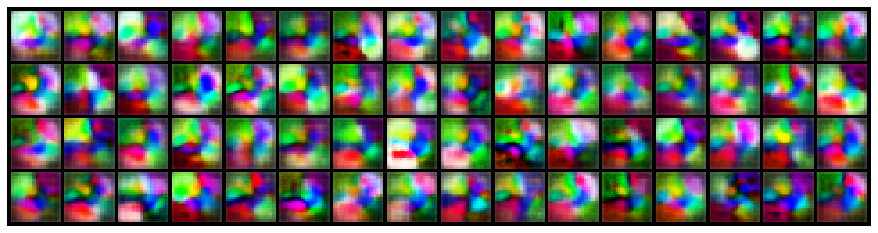

In [30]:
frame.imshow(figsize=(12, 6), show=True, cmap=cmap)

plt.savefig(
    f'../.imgs/notebook_out.png',
    bbox_inches='tight',
    pad_inches=0.0,
)

In [31]:
num_imgs = 32
msgs_from = T.randn(num_imgs, msg_size).to('cuda')
msgs_mid = T.randn(num_imgs, msg_size).to('cuda')
msgs_to = T.randn(num_imgs, msg_size).to('cuda')

In [32]:
lerped_inputs = T.cat([
    T.lerp(
        T.lerp(msgs_from, msgs_mid, T.sin(l) * 0.5 + 0.5),
        msgs_to,
        T.cos(l) * 0.5 + 0.5
    )
    for l in T.arange(0, 2 * np.pi, 0.1).cuda()
], dim=0)

In [33]:
frames = model.encoder(lerped_inputs)

In [34]:
frames = frames.reshape(-1, num_imgs, *frames.shape[-3:])
frames.shape

torch.Size([63, 32, 3, 28, 28])

In [35]:
with vis.vid(vid_path=f'../.videos/lerp-color-{cmap}.webm', fps=30) as vid:
    for f in frames:
        frame = f.reshape(8, 4, *f.shape[-3:])
        frame = frame.imshow(figsize=(12, 6), show=False, cmap=cmap)

        vid.append(frame)

In [36]:
vid.show()